In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set(style="ticks")

In [6]:
def df_ols(df, y, x):
    for var in [x, y]:
        if not hasattr(var, '__iter__'):
            var = [var]
    return pd.ols(y=df[y], x=df[x])

In [7]:
def fix_issue_date(x):
    try:
        return pd.Period(datetime.datetime.strptime(str(x), '%b-%y'), 'M')
    except: 
        return None

In [8]:
def create_relevant_subset(df, grades=['A','B','C','D','E','F','G'], edate='20130101'):
    df['loan_status'] = df['loan_status'].str.replace('Does not meet the credit policy. Status:', '')
    df = df.iloc[df['loan_status'].isin(['Fully Paid', 'Charged Off']).index, :].reset_index(drop=True)
    df = df[df['term'] == ' 36 months']
    df = df[df['grade'].isin(grades)]
    df['issue_d'] = df['issue_d'].map(fix_issue_date).reindex()
    df = df[df['issue_d'] < pd.Period(edate, freq='M')]
    return df

In [9]:
def create_factors(short_df):
    # create y variables
    short_df['defaulted'] = short_df['loan_status'].isin(['Charged Off']).astype(int)
    
    short_df['profit'] = short_df['total_pymnt'] / short_df['funded_amnt']
    short_df['annualized_profit'] = short_df['profit'] ** (1.0/3.0)
    short_df['annualized_ten_percent'] = short_df['annualized_profit']
    
    
    # create x variables
    short_df['verified'] = (~short_df['verification_status'].str.lower().str.contains('not')).astype(int)
    
    purpose_dummies = pd.get_dummies(short_df['purpose'])
    purpose_dummies.columns = ['purpose_' + column for column in purpose_dummies.columns]
    purposes = purpose_dummies.columns
    for purpose in purposes:
        purpose_dummies[purpose] = purpose_dummies[purpose].astype(float)
    short_df = pd.concat([short_df, purpose_dummies], axis=1)
    
    short_df['own_home'] = short_df['home_ownership'].isin(['MORTGAGE', 'OWN'])
    short_df['joint_account'] = short_df['application_type'].isin(['JOINT'])
    
    states_dummies = pd.get_dummies(short_df['addr_state'])
    states_dummies.columns = ['state_' + column for column in states_dummies.columns]
    states = states_dummies.columns
    short_df = pd.concat([short_df, states_dummies], axis=1)
    
    latest = short_df['earliest_cr_line'].map(fix_issue_date).reindex()
    short_df['credit_history'] = np.maximum((short_df['issue_d'] - latest), 1)
    
    import string
    short_df['grade_int'] = short_df['grade'].apply(lambda x: string.lowercase.index(x.lower()))
    
    short_df['dti'] = short_df['dti'] / 100
    
    for column in ['int_rate', 'revol_util']:
        short_df[column] = short_df[column].str.replace('%', '').astype(float) / 100
        
    short_df['emp_length'] = short_df['emp_length'].str.replace('n/a', '0').str.replace('<', '0').str.replace('+', '').str.split(' ').str[0]
    
    for column in ['id', 'member_id', 'loan_amnt', 'dti', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_bal', 
               'revol_util', 'annual_inc', 'open_acc', 'total_acc', 'credit_history', 'emp_length', 'own_home',
               'pub_rec', 'installment', 'mths_since_last_major_derog', 'joint_account']:
        short_df[column] = short_df[column].astype(float)
        
    for column in ['loan_status']:
        short_df[column] = short_df[column].astype(str)
    return short_df, purposes, states

In [10]:
def remove_nans(short_df):
    # fill nans
    short_df['inq_last_6mths'] = short_df['inq_last_6mths'].fillna(0)
    short_df['delinq_2yrs'] = short_df['delinq_2yrs'].fillna(0)
    
    short_df['pub_rec'] = short_df['pub_rec'].fillna(0)
    short_df['total_acc'] = short_df['total_acc'].fillna(0)
    short_df['annual_inc'] = short_df['annual_inc'].fillna(short_df['annual_inc'].mean())
    short_df['open_acc'] = short_df['open_acc'].fillna(short_df['open_acc'].mean())
    short_df['revol_util'] = short_df['revol_util'].fillna(short_df['revol_util'].median())
    
    for column in ['mths_since_last_delinq', 'mths_since_last_record',]:#'mths_since_last_major_derog']:
        short_df[column] = short_df[column].fillna(short_df[column].max())
    
    return short_df

In [11]:
def plot_regression(training_df, y, x, m_t=-10.0, grades=['A', 'B', 'C', 'D', 'E', 'F', 'G'], xlim=[-0.1, 1.1]):
    df = training_df.pipe(create_relevant_subset, grades=grades).pipe(create_factors)[0].pipe(remove_nans) 
    
    model_vs_actual = pd.concat([df.pipe(df_ols, y=y, x=x).y_predict, df[y]], axis=1, keys=['model', 'actual'])
    
    model_vs_actual[model_vs_actual['model'] > m_t].plot.scatter('actual', 'model', sharex=False, title='{}: model vs actual'.format(y))
    plt.show()
    
    model_vs_actual[model_vs_actual['model'] > m_t].plot.hexbin('actual', 'model', sharex=False, title='{}: model vs actual'.format(y))
    plt.xlim(xlim)
    plt.show()
    
    model_vs_actual['actual'].plot.hist(bins=100, title='{}: actual'.format(y))
    plt.xlim(xlim)
    plt.show()
    
    return model_vs_actual

In [12]:
def plot_test_training(testing_df, training_df, y, x, m_t, grades=['A', 'B', 'C', 'D', 'E', 'F', 'G'], xlim=[-0.1, 1.1]):
    reg_test_df = testing_df.pipe(create_relevant_subset, grades=grades).pipe(create_factors)[0].pipe(remove_nans) 
    reg_train_betas = training_df.pipe(create_relevant_subset, grades=grades).pipe(create_factors)[0].pipe(remove_nans).pipe(df_ols, y=y, x=xs).beta
    test_betas = pd.concat([reg_test_df[column] * reg_train_betas[column] for column in reg_train_betas.index if column in reg_test_df], axis=1)
    model_vs_actual = pd.concat([test_betas.sum(axis=1) + reg_train_betas['intercept'], reg_test_df[y]], axis=1, keys=['model', 'actual'])
    model_vs_actual[model_vs_actual['model'] > m_t].plot.scatter('actual', 'model', sharex=False, title='{}: model vs actual'.format(y))
    plt.show()
    
    model_vs_actual[model_vs_actual['model'] > m_t].plot.hexbin('actual', 'model', sharex=False, title='{}: model vs actual'.format(y))
    plt.xlim(xlim)
    plt.show()
    
    model_vs_actual['actual'].plot.hist(bins=100, title='{} actual'.format(y))
    plt.xlim(xlim)
    plt.show()
    
    return model_vs_actual

In [13]:
downloads = '/Users/thegator12321/Downloads/'

In [14]:
training = pd.read_csv('{}{}'.format(downloads, 'LoanStats3a.csv'))
testing = pd.read_csv('{}{}'.format(downloads, 'LoanStats3b.csv'))

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
training.pipe(create_relevant_subset).pipe(create_factors)[0]['annualized_profit'].describe()

count    31534.000000
mean         1.015815
std          0.108587
min          0.000000
25%          1.027587
50%          1.043288
75%          1.060458
max          1.164457
Name: annualized_profit, dtype: float64

In [16]:
testing.pipe(create_relevant_subset).pipe(create_factors)[0]['annualized_profit'].describe()

count    43470.000000
mean         1.021463
std          0.103498
min          0.000000
25%          1.030395
50%          1.048352
75%          1.067029
max          1.126129
Name: annualized_profit, dtype: float64

In [17]:
# choose which grades to regress
grades = [
    'A',
    'B',
    'C',
    'D', 
    'E', 
    'F', 
    'G'
]

In [18]:
# get the purposes and states to use as x_variables
_, purposes, states = training.pipe(create_relevant_subset, grades=grades).pipe(create_factors)

In [27]:
# pick the x and y variables to use in the regression
xs = [
    'dti', 
    'int_rate',
    'loan_amnt', 
    #'mths_since_last_delinq', 
    #'mths_since_last_record',
    # 'mths_since_last_major_derog',
    'revol_bal',
    'revol_util',
    'annual_inc',
    'open_acc',
    'total_acc',
    'pub_rec',
    'grade_int',
    'credit_history',
    'emp_length',
    'verified',
    'own_home',
    'installment',
    'delinq_2yrs',
    'inq_last_6mths',
    'joint_account'
] + purposes.tolist() + states.tolist()

y = [
    'defaulted',
    # 'profit',
    'annualized_profit'
]

training.pipe(create_relevant_subset).pipe(create_factors)[0].loc[:, xs + y]

,dti,int_rate,loan_amnt,revol_bal,revol_util,annual_inc,open_acc,total_acc,pub_rec,grade_int,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,defaulted,annualized_profit
0,0.2765,0.1065,5000,13648,0.8370,24000.00,3,9,0,1,...,0,0,0,0,0,0,0,0,0,1.054393
2,0.0872,0.1596,2400,2956,0.9850,12252.00,2,10,0,2,...,0,0,0,0,0,0,0,0,0,1.077654
3,0.2000,0.1349,10000,5598,0.2100,49200.00,10,37,0,2,...,0,0,0,0,0,0,0,0,0,1.069297
5,0.1120,0.0790,5000,7963,0.2830,36000.00,9,12,0,0,...,0,0,0,0,0,0,0,0,0,1.040435
7,0.0535,0.1864,3000,8221,0.8750,48000.00,4,4,0,4,...,0,0,0,0,0,0,0,0,0,1.094940
11,0.1078,0.1269,12000,23336,0.6710,75000.00,12,34,0,1,...,0,0,0,0,0,0,0,0,0,1.051298
12,0.1008,0.1349,9000,10452,0.9170,30000.00,4,9,0,2,...,0,0,1,0,0,0,0,0,1,0.631887
13,0.1256,0.0991,3000,7323,0.4310,15000.00,11,11,0,1,...,0,0,0,0,0,0,0,0,0,1.050615
14,0.0706,0.1065,10000,11997,0.5550,100000.00,14,29,0,1,...,0,0,0,0,0,0,0,0,1,0.907428
15,0.2031,0.1629,1000,6524,0.8150,28000.00,11,23,0,3,...,0,0,0,0,0,0,0,0,0,1.082981


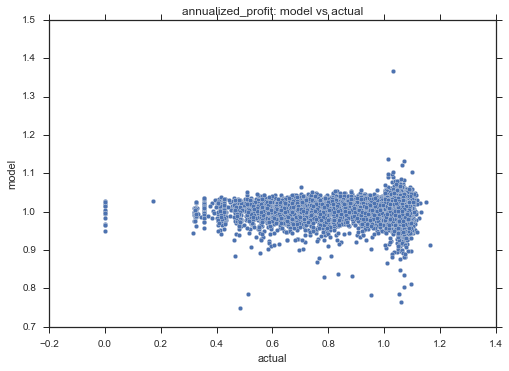

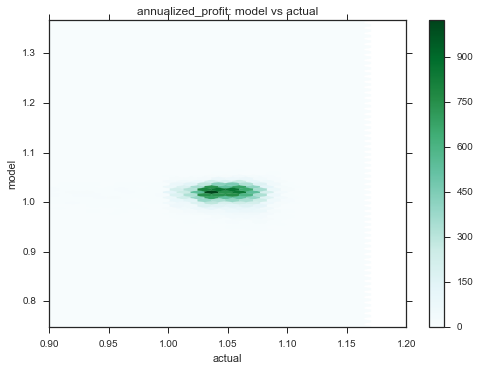

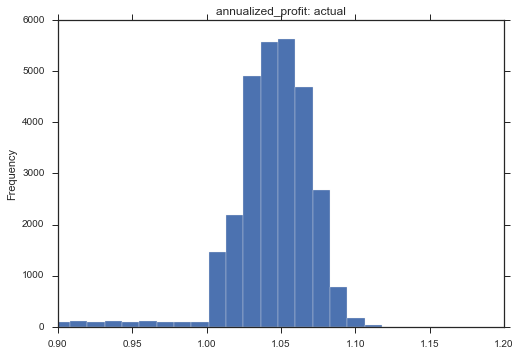

In [20]:
# plot the training model
model_vs_actual_train = plot_regression(training, y[0], xs, m_t=0, grades=grades, xlim=[0.9, 1.2])

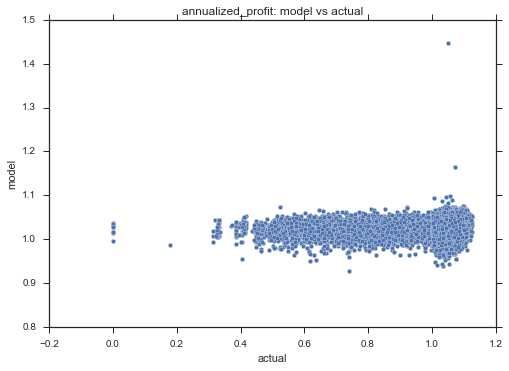

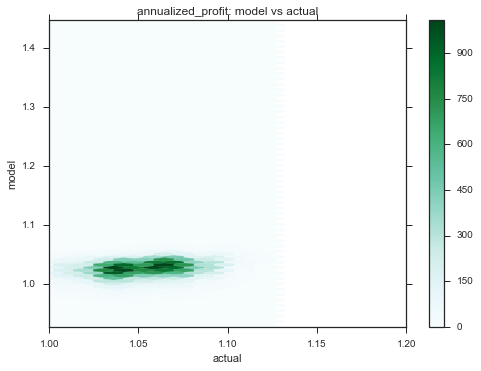

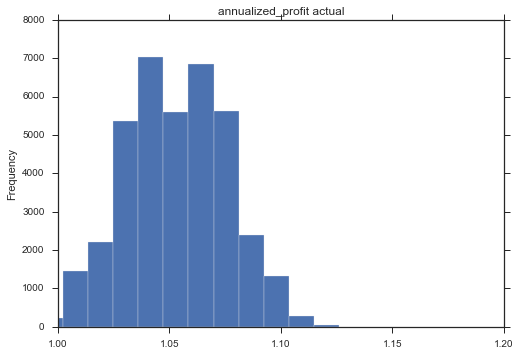

In [21]:
# apply the training model to the testing data
model_vs_actual_test = plot_test_training(testing, training, y[0], xs, m_t=0.0, xlim=[1.0, 1.2], grades=grades)

In [22]:
model_vs_actual_train.head(5)

,model,actual
0,1.020369,1.054393
2,0.988406,1.077654
3,1.004299,1.069297
5,0.996383,1.040435
7,1.007505,1.094940


In [23]:
model_vs_actual_test.head(5)

,model,actual
133641,1.019949,1.088112
133740,1.019691,1.067036
133762,1.019426,1.056379
133863,1.030513,1.058550
133870,1.012380,1.073990
